# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.


Несмотря на то, что основная причина использования Negative Sampling - улучшение скорости тренировки word2vec, в нашем игрушечном примере мы **не требуем** улучшения производительности. Мы используем negative sampling просто как дополнительное упражнение для знакомства с PyTorch.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

/Users/haimo/Documents/study/DL/.venv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []
        self.sentences = []
        self.token_freq = {}
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("../data/stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
studio ['oscar-winning', 'lowly']
aimed ['obviously', 'country', 'bears']
world ['hews', 'a', 'darkness']
seamless ['dream', 'solid', 'ensemble', '.']
problem ['added', 'ingredients']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [3]:
import random

num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        '''
        Initializes Word2VecNegativeSampling, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_negative_samples - number of negative samples to generate in addition to a positive one
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_negative_samples = num_negative_samples
        self.num_contexts = num_contexts
        self.num_tokens = data.num_tokens()
        self.context_lenght = 5
        self.samples = []
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        self.samples = []
        for _ in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(self.context_lenght)

            input_idx = self.data.index_by_token[center_word]
            pos_indices = [self.data.index_by_token[out_idx] for out_idx in other_words]
            output_indices = [[pos_idx] + [random.randint(0, data.num_tokens()-1) for _ in range(self.num_negative_samples)] for pos_idx in pos_indices]

            self.samples.extend((input_idx, out_idx) for out_idx in output_indices)
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - index of the input word (not torch.Tensor!)
        output_indices - torch.Tensor of indices of the target words. Should be 1+num_negative_samples.
        output_target - torch.Tensor with float targets for the training. Should be the same size as output_indices
                        and have 1 for the context word and 0 everywhere else
        '''
        in_idx, output_indices = self.samples[index]

        # new_pos_idx = 0
        pos_idx, new_pos_idx = 0, random.randint(0, len(output_indices)-1)
        output_indices[pos_idx], output_indices[new_pos_idx] = output_indices[new_pos_idx], output_indices[pos_idx]
        output_indices = torch.tensor(output_indices)

        output_target = torch.nn.functional.one_hot(torch.tensor([new_pos_idx]), len(output_indices)).T

        return in_idx, output_indices, output_target


dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 12599, output indices: tensor([ 5249,    45,  9627,  2266,   324,  5117, 11553,  7626,  1069,  9588,
        14446]), output target: tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.  
Напомним, что цели улучшить скорость тренировки у нас нет, достаточно чтобы она сходилась.

In [4]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()

# As before, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, 10, bias=False)
        self.output = nn.Linear(10, num_tokens, bias=False)
        
    def forward(self, input_index_batch, output_indices_batch):
        '''
        Implements forward pass with negative sampling
        
        Arguments:
        input_index_batch - Tensor of ints, shape: (batch_size, ), indices of input words in the batch
        output_indices_batch - Tensor if ints, shape: (batch_size, num_negative_samples+1),
                                indices of the target words for every sample
                                
        Returns:
        predictions - Tensor of floats, shape: (batch_size, um_negative_samples+1)
        '''
        results = []
        
        for idx, input_idx in enumerate(input_index_batch):
            output_indices = output_indices_batch[idx]

            u = self.input.weight[:, input_idx]
            v = self.output.weight[output_indices, :]

            results.append(torch.mv(v, u))

        return torch.stack(results)

    
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.FloatTensor)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (output): Linear(in_features=10, out_features=19538, bias=False)
)

In [5]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos
    return nn_model.input.weight.T, nn_model.output.weight

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [6]:
untrained_input_vectors.T.shape, untrained_output_vectors.shape

(torch.Size([10, 19538]), torch.Size([19538, 10]))

In [7]:
def train_neg_sample(model, dataset, train_loader, optimizer, scheduler, num_epochs):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        dataset.generate_dataset()

        loss_accum = correct_samples = total_samples = 0
        for i, (x1, x2, y) in enumerate(train_loader):
            pred = model(x1, x2)
            y = y.reshape(y.shape[0], -1)
            y = y.to(torch.float32)
            loss_val = loss(pred, y)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            _, indices = torch.max(pred, 1)
            y = torch.argmax(y, 1)
            # print(indices.shape, y.shape)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_val
        
        scheduler.step()
        
        ave_loss = loss_accum / i
        train_accuracy = correct_samples / total_samples

        loss_history.append(ave_loss)
        train_history.append(train_accuracy)

        print(f"Epoch: {epoch}, Average loss: {ave_loss}, Train accuracy: {train_accuracy}")
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [38]:
from collections import namedtuple

Hyperparams = namedtuple("Hyperparams", ['optimizer', 'batch_size', 'learning_rate', 'momentum', 'weight_decay', 'anneal_epochs', 'anneal_coeff'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'loss_history'])
run_record = {}

In [43]:
# Finally, let's train the model!
batch_size_list = [64, 128]
anneal_epochs=20
anneal_coeff=0.1
lr=1e-3
wd=0
momentum = [0, 0.99]
epochs=3

# train with SGD
for m in momentum:
    for batch_size in batch_size_list:
        params = Hyperparams('sgd', batch_size, lr, m, wd, anneal_epochs, anneal_coeff)
        print(params)

        nn_model = Word2VecNegativeSamples(data.num_tokens())
        nn_model.type(torch.FloatTensor)
        
        optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=wd, momentum=m)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        
        loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, epochs)
        run_record[params] = RunResult(nn_model, train_history, loss_history)

# train with Adam
for batch_size in batch_size_list:
    params = Hyperparams('adam', batch_size, lr, m, wd, anneal_epochs, anneal_coeff)
    print(params)

    nn_model = Word2VecNegativeSamples(data.num_tokens())
    nn_model.type(torch.FloatTensor)
    
    optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, epochs)
    run_record[params] = RunResult(nn_model, train_history, loss_history)

Hyperparams(optimizer='adam', batch_size=64, learning_rate=0.001, momentum=0, weight_decay=0, anneal_epochs=20, anneal_coeff=0.1)
Epoch: 0, Average loss: 0.6933278441429138, Train accuracy: 0.09898906946182251
Epoch: 1, Average loss: 0.6710478067398071, Train accuracy: 0.16471639275550842
Epoch: 2, Average loss: 0.582388699054718, Train accuracy: 0.24997584521770477
Hyperparams(optimizer='adam', batch_size=128, learning_rate=0.001, momentum=0, weight_decay=0, anneal_epochs=20, anneal_coeff=0.1)
Epoch: 0, Average loss: 0.6941770911216736, Train accuracy: 0.09746567159891129
Epoch: 1, Average loss: 0.6896583437919617, Train accuracy: 0.1304289996623993
Epoch: 2, Average loss: 0.6463924646377563, Train accuracy: 0.209404855966568


/var/folders/wd/_fgjf67n0rlgd1_0pyytpbd00000gn/T/ipykernel_21614/3272821117.py:5: MatplotlibDeprecationWarning: Passing label as a length 7 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(run_result.train_history, label=hyperparams)
/var/folders/wd/_fgjf67n0rlgd1_0pyytpbd00000gn/T/ipykernel_21614/3272821117.py:9: MatplotlibDeprecationWarning: Passing label as a length 7 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(run_result.loss_history, label=hyperparams)


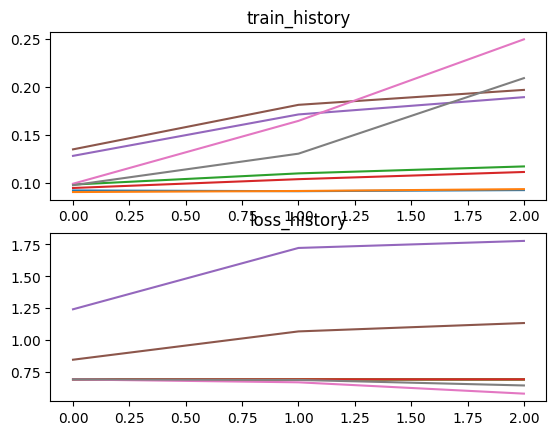

In [44]:
# Visualize training graphs
for hyperparams, run_result in run_record.items():
    plt.subplot(211)
    plt.title('train_history')
    plt.plot(run_result.train_history, label=hyperparams)

    plt.subplot(212)
    plt.title('loss_history')
    plt.plot(run_result.loss_history, label=hyperparams)

In [45]:
min([run_result.loss_history[-1] for _, run_result in run_record.items()]), max([run_result.train_history[-1] for _, run_result in run_record.items()])

(0.582388699054718, tensor(0.2500))

/var/folders/wd/_fgjf67n0rlgd1_0pyytpbd00000gn/T/ipykernel_21614/776090123.py:12: MatplotlibDeprecationWarning: Passing label as a length 7 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(run_result.train_history, label=hyperparams)


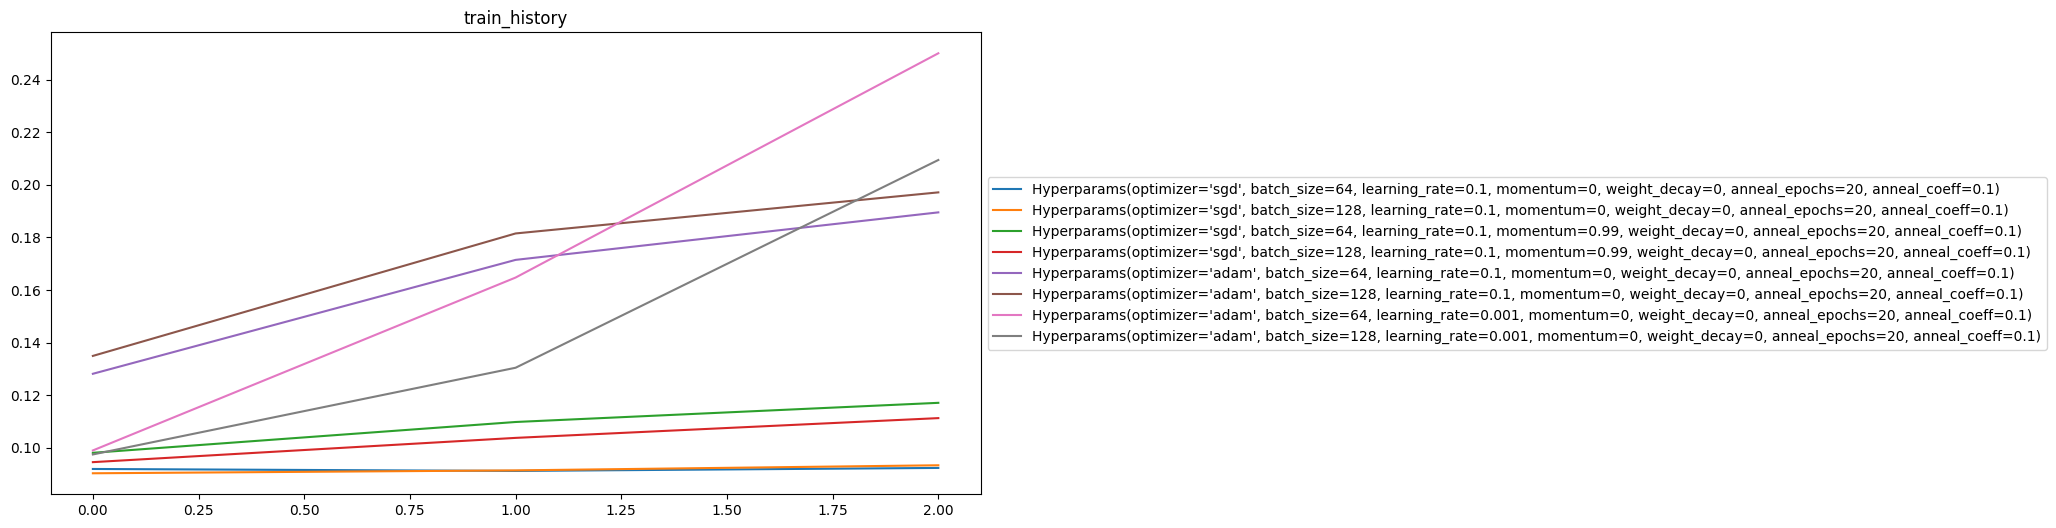

In [48]:
# results_to_display = []
# for hyperparams, run_result in run_record.items():
#     if run_result.loss_history[-1] < 0.6:
#         results_to_display.append((run_record[hyperparams].train_history, hyperparams))
#         print(f"loss: {run_result.loss_history[-1]:.4f},\naccuracy: {run_result.train_history[-1]:.4f},\nparams: {hyperparams}\n")
        
# Visualize training graphs
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(111)
plt.title('train_history')
for hyperparams, run_result in run_record.items():
    ax.plot(run_result.train_history, label=hyperparams)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
# best_model
batch_size=64
anneal_epochs=10
anneal_coeff=0.1
lr=1e-2
wd=0
epochs=20

nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, epochs)

Epoch: 0, Average loss: 0.5872339010238647, Train accuracy: 0.14926311373710632
Epoch: 1, Average loss: 0.353084921836853, Train accuracy: 0.2675156891345978
Epoch: 2, Average loss: 0.3121238946914673, Train accuracy: 0.2984572947025299
Epoch: 3, Average loss: 0.29698699712753296, Train accuracy: 0.32194432616233826
Epoch: 4, Average loss: 0.2911316156387329, Train accuracy: 0.33646607398986816
Epoch: 5, Average loss: 0.2888127267360687, Train accuracy: 0.35004302859306335
Epoch: 6, Average loss: 0.28355926275253296, Train accuracy: 0.3721206486225128
Epoch: 7, Average loss: 0.2800941467285156, Train accuracy: 0.38597506284713745
Epoch: 8, Average loss: 0.2754327654838562, Train accuracy: 0.40385687351226807
Epoch: 9, Average loss: 0.27206721901893616, Train accuracy: 0.4133583605289459
Epoch: 10, Average loss: 0.26493680477142334, Train accuracy: 0.41885948181152344
Epoch: 11, Average loss: 0.2549184262752533, Train accuracy: 0.43109941482543945
Epoch: 12, Average loss: 0.248106047511

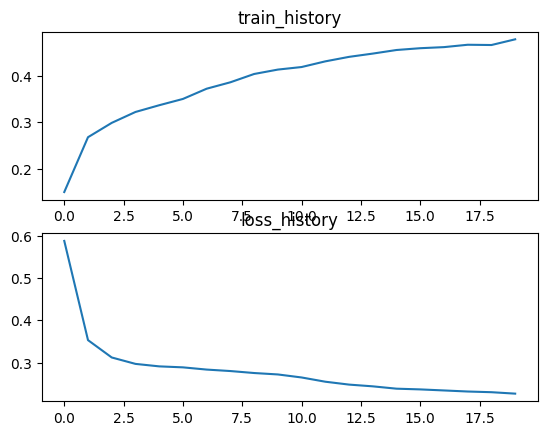

In [20]:
# Visualize training graphs
plt.subplot(211)
plt.title('train_history')
plt.plot(train_history)

plt.subplot(212)
plt.title('loss_history')
plt.plot([loss.detach() for loss in loss_history])

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

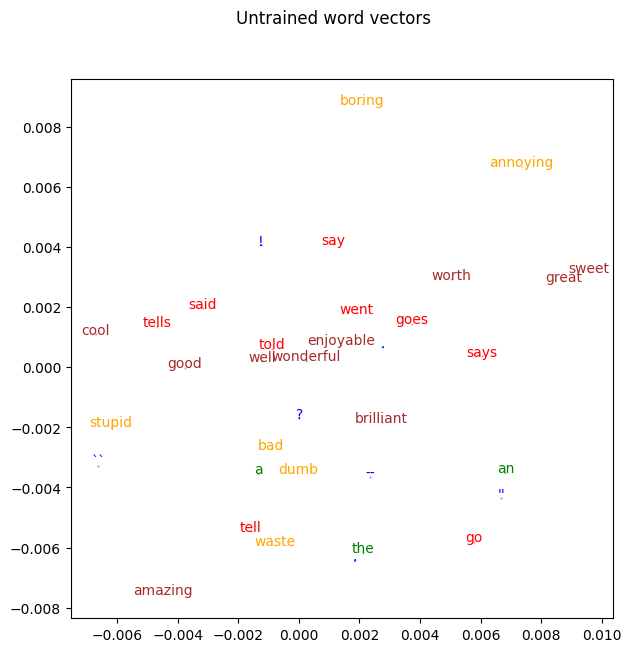

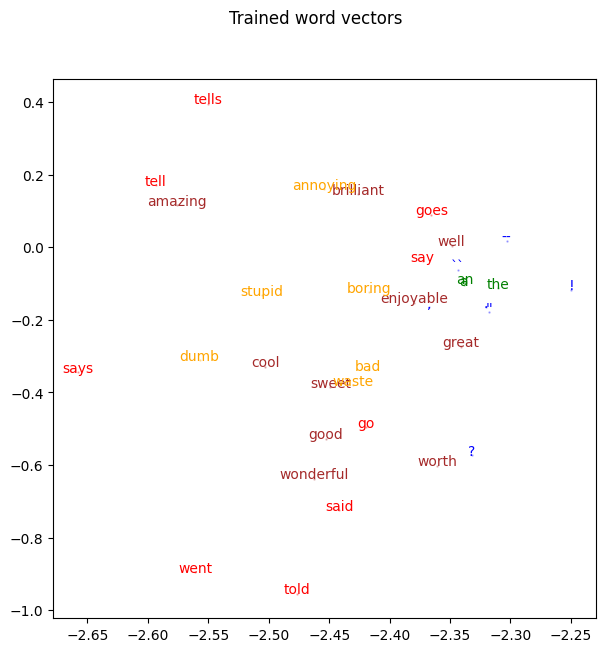

In [21]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")